This notebook documents experiments using the FNO model for geostrophic current prediction. The model is based on Li et al. (2020) but incorporates modifications to the Fourier layer using the FNO-MLP approach from Qin et al. (2024).

 Li, Z., Kovachki, N., Azizzadenesheli, K., Liu, B., Bhattacharya, K., Stuart, A., & Anandkumar, A. (2020). Fourier neural operator for parametric partial differential equations. arXiv preprint arXiv:2010.08895.

 Qin, S., Lyu, F., Peng, W., Geng, D., Wang, J., Gao, N., ... & Wang, L. L. (2024). Toward a Better Understanding of Fourier Neural Operators: Analysis and Improvement from a Spectral Perspective. arXiv preprint arXiv:2404.07200.

## Modified FNO-MLP layer

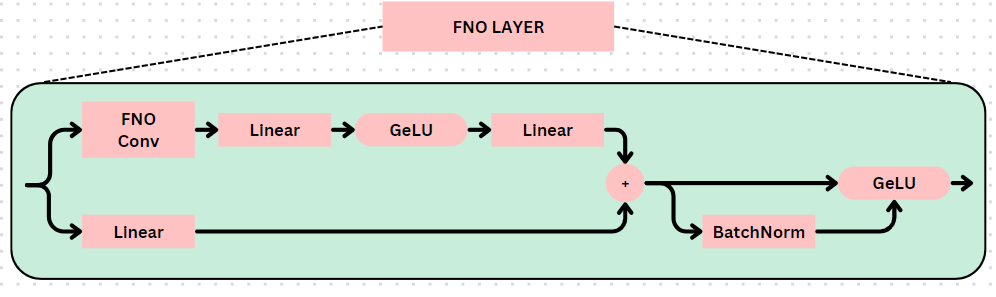

# Data Preprocessing

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from datetime import date
import torch.nn.functional as F
import pickle

In [ ]:
import pickle
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')
with open('/content/drive/MyDrive/paper/raw_data.pickle','rb') as r:
    raw_data = pickle.load(r)

Mounted at /content/drive


Preprocessing function

In [ ]:
def parse(date_string):
    return [int(i) for i in date_string.split('-')]

def get_split_index(start_index,end_index,start_date,end_date):
    '''
    Calculate the start and end indices for a given date range.

    Args:
        start_index (str): The start date index in the format 'YYYY-MM-DD'.
        end_index (str): The end date index in the format 'YYYY-MM-DD'.
        start_date (str): The start date of the date range in the format 'YYYY-MM-DD'.
        end_date (str): The end date of the date range in the format 'YYYY-MM-DD'.

    Returns:
        tuple: A tuple containing two integers:
            - index_start (int): The number of days from the start_date to start_index.
            - index_end (int): The number of days from the start_date to end_index, plus one.
    '''
    ys,ms,ds = parse(start_index)
    ye,me,de = parse(end_index)
    ysd,msd,dsd = parse(start_date)
    yed,med,ded = parse(end_date)
    start_time = date(ys,ms,ds)
    end_time   = date(ye,me,de)
    start_time_date = date(ysd,msd,dsd)
    end_time_date   = date(yed,med,ded)
    index_start = (start_time - start_time_date).days
    index_end   = (end_time - start_time_date).days+1
    if index_start < 0 or (end_time - end_time_date).days > 0 or end_time==start_time:
        raise ValueError(f'index date invalid with condition {index_start} < 0 or {(end_time - end_time_date).days} > 0 or {end_time} == {start_time}')
    return index_start,index_end

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Because the data have island which encoded as NaN
# The need to fill the nan data is necessary
# we use interpolation 2D

def interpolate_nan_cubic(arr,method):
    # Coordinates of non-NaN values
    x, y = np.meshgrid(np.arange(arr.shape[1]), np.arange(arr.shape[0]))
    x = x[~np.isnan(arr)]
    y = y[~np.isnan(arr)]
    points = (x, y)

    # Values of non-NaN elements
    values = arr[~np.isnan(arr)]

    # Grid to interpolate onto
    xi, yi = np.meshgrid(np.arange(arr.shape[1]), np.arange(arr.shape[0]))

    # Perform cubic interpolation
    arr_interp = griddata(points, values, (xi, yi), method=method)

    return arr_interp

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Load data to

class FNOData():
    def __init__(self,
                 start_index_date,
                 split_index_date,
                 end_index_date,
                 number_in = 1,
                 number_out = 5,
                 start_date="2013-01-01",
                 end_date="2021-12-31"
                 ):
        self.start, self.split = get_split_index(start_index_date, split_index_date,start_date,end_date)
        _         , self.end   = get_split_index(split_index_date, end_index_date,  start_date,end_date)
        self.number_in = number_in
        self.number_out = number_out
        self.mask = None

    def process_nan(self,X_u,X_v,X_adt,Y_u,Y_v,train):
        if self.mask is None and train:
          self.mask = {}
          self.mask['u']   = X_u.nanmean()#axis=[1,2])
          self.mask['v']   = X_v.nanmean()#axis=[1,2])
          self.mask['adt'] = X_adt.nanmean()#axis=[1,2])
        elif train is None:
            AssertionError
        X_u = torch.nan_to_num(X_u, self.mask['u'])
        X_v = torch.nan_to_num(X_v, self.mask['v'])
        X_adt = torch.nan_to_num(X_adt, self.mask['adt'])
        Y_u = torch.nan_to_num(Y_u, self.mask['u'])
        Y_v = torch.nan_to_num(Y_v, self.mask['v'])

        return X_u,X_v,X_adt,Y_u,Y_v

    def transform(self,data,train):
        if train:
            upper_bound = self.start
            lower_bound = self.split
        else:
            upper_bound = self.split
            lower_bound = self.end
        for index in range(len(data['center'])):
            # mean_adt = np.nanmean(data['center'][index])
            # mean_u = np.nanmean(data['u_geos'][index])
            # mean_v = np.nanmean(data['v_geos'][index])
            #data['center'][index] = interpolate_nan_cubic(interpolate_nan_cubic(raw_data['center'][index],'linear'),'nearest')#np.nan_to_num(data['center'][index], nan=mean_adt)
            data['u_geos'][index] = interpolate_nan_cubic(interpolate_nan_cubic(raw_data['u_geos'][index],'linear'),'nearest')#np.nan_to_num(data['u_geos'][index], nan=mean_adt)
            data['v_geos'][index] = interpolate_nan_cubic(interpolate_nan_cubic(raw_data['v_geos'][index],'linear'),'nearest')#np.nan_to_num(data['v_geos'][index], nan=mean_adt)
        X_u = []
        X_v = []
        X_adt = []
        for input_n in range(self.number_in-1,-1,-1):
          X_u.append(torch.tensor(np.array(data['u_geos'][max(0,upper_bound-self.number_in+1):min(lower_bound+self.number_out,3287)])).roll(input_n,dims=0)[self.number_in-1:-self.number_out,:,:])
          X_v.append(torch.tensor(np.array(data['v_geos'][max(0,upper_bound-self.number_in+1):min(lower_bound+self.number_out,3287)])).roll(input_n,dims=0)[self.number_in-1:-self.number_out,:,:])
          X_adt.append(torch.tensor(np.array(data['center'][max(0,upper_bound-self.number_in+1):min(lower_bound+self.number_out,3287)])).roll(input_n,dims=0)[self.number_in-1:-self.number_out,:,:])
        Y_u = []
        Y_v = []
        for output_n in range(1,self.number_out+1):
            Y_u.append(torch.tensor(np.array(data['u_geos'][max(0,upper_bound-self.number_in+1):min(lower_bound+self.number_out,3287)])).roll(-output_n,dims=0)[self.number_in-1:-self.number_out,:,:])
            Y_v.append(torch.tensor(np.array(data['v_geos'][max(0,upper_bound-self.number_in+1):min(lower_bound+self.number_out,3287)])).roll(-output_n,dims=0)[self.number_in-1:-self.number_out,:,:])
        X_u = torch.stack(X_u,dim=-1)
        X_v = torch.stack(X_v,dim=-1)
        X_adt = torch.stack(X_adt,dim=-1)

        Y_u = torch.stack(Y_u,dim=-1)
        Y_v = torch.stack(Y_v,dim=-1)
        return X_u,X_v,X_adt,Y_u,Y_v

    def get_data(self,data):
        train_X_u,train_X_v,train_X_adt,train_Y_u,train_Y_v = self.transform(data,train=True)
        test_X_u ,test_X_v ,test_X_adt ,test_Y_u ,test_Y_v  = self.transform(data,train=False)
        # train_X_u,train_X_v,train_X_adt,train_Y_u,train_Y_v = self.process_nan(train_X_u,train_X_v,train_X_adt,train_Y_u,train_Y_v, train = True)
        # test_X_u ,test_X_v ,test_X_adt ,test_Y_u ,test_Y_v  = self.process_nan(test_X_u ,test_X_v ,test_X_adt ,test_Y_u ,test_Y_v, train = False)
        train = [train_X_u.float(),train_X_v.float(),train_X_adt.float(),train_Y_u.float(),train_Y_v.float()]
        test =  [test_X_u.float() ,test_X_v.float() ,test_X_adt.float() ,test_Y_u.float() ,test_Y_v.float() ]
        print(len(train))
        return train, test


In [ ]:
dataset=FNOData("2013-01-01","2018-12-31","2021-12-31",number_in = 7,number_out = 5)

In [ ]:
train_data, test_data = dataset.get_data(raw_data)

In [ ]:
import pickle
# with open('/content/drive/MyDrive/paper/FNO_train.picle', 'wb') as f:
#     pickle.dump(train_data, f)

# with open('/content/drive/MyDrive/paper/FNO_test.picle', 'wb') as f:
#     pickle.dump(test_data, f)


with open('/content/drive/MyDrive/paper/FNO_train.picle', 'rb') as f:
    train_data = pickle.load(f)

with open('/content/drive/MyDrive/paper/FNO_test.picle', 'rb') as f:
    test_data = pickle.load(f)

In [ ]:
################################################################
# fourier layer
################################################################

class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, in_time, out_time,do_percentage):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """
        self.do_percentage = do_percentage
        self.in_time = in_time
        self.out_time = out_time
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3+2, self.width)
        #self.fc1 = nn.Linear(self.width, self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        self.fc0_U = nn.Linear(self.in_time+2, self.width)
        self.conv0_U = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1_U = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2_U = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3_U = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv4_U = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0_U = nn.Conv2d(self.width, self.width, 1)
        self.w1_U = nn.Conv2d(self.width, self.width, 1)
        self.w2_U = nn.Conv2d(self.width, self.width, 1)
        self.w3_U = nn.Conv2d(self.width, self.width, 1)
        self.w4_U = nn.Conv2d(self.width, self.width, 1)
        self.fc1_U = nn.Linear(self.width, 128)
        self.fc2_U = nn.Linear(128, self.out_time)

        self.fc0_V = nn.Linear(self.in_time+2, self.width)
        self.conv0_V = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1_V = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2_V = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3_V = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv4_V = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0_V = nn.Conv2d(self.width, self.width, 1)
        self.w1_V = nn.Conv2d(self.width, self.width, 1)
        self.w2_V = nn.Conv2d(self.width, self.width, 1)
        self.w3_V = nn.Conv2d(self.width, self.width, 1)
        self.w4_V = nn.Conv2d(self.width, self.width, 1)
        self.fc1_V = nn.Linear(self.width, 128)
        self.fc2_V = nn.Linear(128, self.out_time)

        self.fc0_adt = nn.Linear(self.in_time+2, self.width)
        self.conv0_adt = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1_adt = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2_adt = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3_adt = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv4_adt = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0_adt = nn.Conv2d(self.width, self.width, 1)
        self.w1_adt = nn.Conv2d(self.width, self.width, 1)
        self.w2_adt = nn.Conv2d(self.width, self.width, 1)
        self.w3_adt = nn.Conv2d(self.width, self.width, 1)
        self.w4_adt = nn.Conv2d(self.width, self.width, 1)
        self.fc1_adt = nn.Linear(self.width, 128)
        self.fc2_adt = nn.Linear(128, self.out_time)

        self.conv_join_U = SpectralConv2d_fast(self.width*2, self.width, self.modes1, self.modes2)
        self.w_join_U = nn.Conv2d(self.width*2, self.width,1)

        self.conv_join_V = SpectralConv2d_fast(self.width*2, self.width, self.modes1, self.modes2)
        self.w_join_V = nn.Conv2d(self.width*2, self.width,1)

        self.batch_norm = torch.nn.BatchNorm2d(self.width)

        self.drop_out = nn.Dropout(p=self.do_percentage)

    def forward(self, X_u, X_v):#, X_adt):
        #init grid
        grid = self.get_grid(X_u.shape, X_u.device)

        #PRE - U

        #attention
        X_u = torch.cat((X_u, grid), dim=-1)
        X_u = self.fc0_U(X_u)
        X_u = X_u.permute(0, 3, 1, 2)

        # X_u1 = self.conv0_U(X_u)
        # X_u2 = self.w0_U(X_u)
        # X_u = X_u1 + X_u2
        # X_u = self.batch_norm(F.gelu(X_u))

        X_u1 = self.conv1_U(X_u)
        X_u2 = self.w1_U(X_u)
        X_u = X_u1 + X_u2
        X_u = self.batch_norm(F.gelu(X_u))
        X_u = self.drop_out(X_u)
        #PRE - V

        #attention
        X_v = torch.cat((X_v, grid), dim=-1)
        X_v = self.fc0_V(X_v)
        X_v = X_v.permute(0, 3, 1, 2)

        # X_v1 = self.conv0_V(X_v)
        # X_v2 = self.w0_V(X_v)
        # X_v = X_v1 + X_v2
        # X_v = self.batch_norm(F.gelu(X_v))

        X_v1 = self.conv1_V(X_v)
        X_v2 = self.w1_V(X_v)
        X_v = X_v1 + X_v2
        X_v = self.batch_norm(F.gelu(X_v))
        X_v = self.drop_out(X_v)
        #PRE - ADT

        #attention
        # X_adt = torch.cat((X_adt, grid), dim=-1)
        # X_adt = self.fc0_adt(X_adt)
        # X_adt = X_adt.permute(0, 3, 1, 2)

        # X_adt1 = self.conv0_adt(X_adt)
        # X_adt2 = self.w0_adt(X_adt)
        # X_adt = X_adt1 + X_adt2
        # X_adt = self.batch_norm(F.gelu(X_adt))

        # X_adt1 = self.conv1_adt(X_adt)
        # X_adt2 = self.w1_adt(X_adt)
        # X_adt = X_adt1 + X_adt2
        # X_adt = self.batch_norm(F.gelu(X_adt))

        #print(X_adt.shape)

        #Join channel
        X = torch.cat([X_u,X_v],dim=1)#,X_adt],dim=1)

        #POST - U
        X_u1 = self.conv_join_U(X)
        X_u2 = self.w_join_U(X)
        X_u  = X_u1 + X_u2
        X_u = self.batch_norm(F.gelu(X_u))
        X_u = self.drop_out(X_u)

        X_u1 = self.conv2_U(X_u)
        X_u2 = self.w2_U(X_u)
        X_u = X_u1 + X_u2
        X_u = self.batch_norm(F.gelu(X_u))
        X_u = self.drop_out(X_u)

        # X_u1 = self.conv3_U(X_u)
        # X_u2 = self.w3_U(X_u)
        # X_u = X_u1 + X_u2
        # X_u = self.batch_norm(F.gelu(X_u))

        X_u = X_u.permute(0, 2, 3, 1)
        X_u = self.fc1_U(X_u)
        X_u = F.gelu(X_u)
        X_u = self.fc2_U(X_u)

        #POST - V
        X_v1 = self.conv_join_V(X)
        X_v2 = self.w_join_V(X)
        X_v  = X_v1 + X_v2
        X_v = self.batch_norm(F.gelu(X_v))
        X_v = self.drop_out(X_v)

        X_v1 = self.conv2_V(X_v)
        X_v2 = self.w2_V(X_v)
        X_v = X_v1 + X_v2
        X_v = self.batch_norm(F.gelu(X_v))
        X_v = self.drop_out(X_v)

        # X_v1 = self.conv3_V(X_v)
        # X_v2 = self.w3_V(X_v)
        # X_v = X_v1 + X_v2
        # X_v = self.batch_norm(F.gelu(X_v))

        X_v = X_v.permute(0, 2, 3, 1)
        X_v = self.fc1_V(X_v)
        X_v = F.gelu(X_v)
        X_v = self.fc2_V(X_v)

        #- x1 = self.conv2(x)
        #- x2 = self.w2(x)
        #- x = x1 + x2
        #- x = F.gelu(x + self.bn2(x))

        #- x1 = self.conv3(x)
        #- x2 = self.w3(x)
        #- x = x1 + x2
        # x = F.gelu(x + self.bn3(x))

        # x1 = self.conv4(x)
        # x2 = self.w4(x)
        # x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        # x = x.permute(0, 2, 3, 1)
        # x = self.fc1(x)
        # x = F.gelu(x)
        # x = self.fc2(x)
        return X_u,X_v

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


In [ ]:
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms

class FNODataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, idx):
        # Example assumes CSV contains image paths and text data
        X_u   = self.data[0][idx,:,:,:]
        X_v   = self.data[1][idx,:,:,:]
        X_adt = self.data[2][idx,:,:,:]
        Y_u   = self.data[3][idx,:,:,:]
        Y_v   = self.data[4][idx,:,:,:]

        return X_u,X_v,X_adt,Y_u,Y_v


In [ ]:
from numpy import linalg as LA
def MSE(outputs, targets):
  """
  Calculate the combined L1 and L2 loss.

  Args:
    outputs (torch.Tensor): The predictions of the model.
    targets (torch.Tensor): The actual values.

    Returns:
    torch.Tensor: The calculated loss.
  """
  num_examples = outputs.shape[0]
  true = targets.reshape(num_examples,-1)
  pred = outputs.reshape(num_examples,-1)
  reconstruction_error = np.mean(np.power((pred-true),2))
  return reconstruction_error

class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

class DifferenceLoss(nn.Module):
    def __init__(self, epsilon=0.001):
        """
        Initialize the loss function.

        Args:
            alpha (float): The weight given to L1 loss. (1 - alpha) will be the weight for L2 loss.
        """
        super(DifferenceLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, outputs, targets):
        """
        Calculate the combined L1 and L2 loss.

        Args:
            outputs (torch.Tensor): The predictions of the model.
            targets (torch.Tensor): The actual values.

        Returns:
            torch.Tensor: The calculated loss.
        """
        num_examples = outputs.size()[0]
        true = targets.reshape(num_examples,-1)
        pred = outputs.reshape(num_examples,-1)
        reconstruction_error= torch.sum(torch.pow((pred-true),2,),dim=1)

        true_diff = torch.diff(targets.reshape(num_examples, -1,5))
        pred_diff = torch.diff(outputs.reshape(num_examples, -1,5))
        difference_error    = torch.sum(torch.pow((pred_diff-true_diff),2),dim=[1,2])

        combined_loss = torch.mean(difference_error+reconstruction_error)
        return combined_loss

In [ ]:
from torch.utils.data import DataLoader
batch_size = 64#64#32
train_dataloader = DataLoader(FNODataset(train_data), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(FNODataset(test_data), batch_size=batch_size)

template_data = torch.isnan(torch.cat([torch.tensor(np.array(raw_data['center'])),
           torch.tensor(np.array(raw_data['u_geos'])),
           torch.tensor(np.array(raw_data['v_geos']))])).any(dim=0)

expanded_mask = template_data.unsqueeze(0).unsqueeze(0).permute(0,2,3,1)
expanded_mask_transformed = expanded_mask.expand(32,91,195,5)

In [ ]:
for u,v,adt,U,V in train_dataloader:
  break

In [ ]:
U[~expanded_mask_transformed].shape[0]/(64*5)

14374.0

In [ ]:
91*195

17745

# multimodal

In [ ]:
################################################################
# fourier layer
################################################################

class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, in_time, out_time):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """
        self.in_time = in_time
        self.out_time = out_time
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3+2, self.width)
        #self.fc1 = nn.Linear(self.width, self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        self.fc0_U = nn.Linear(self.in_time+2, self.width)
        self.conv0_U = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1_U = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2_U = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3_U = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv4_U = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0_U = nn.Conv2d(self.width, self.width, 1)
        self.w1_U = nn.Conv2d(self.width, self.width, 1)
        self.w2_U = nn.Conv2d(self.width, self.width, 1)
        self.w3_U = nn.Conv2d(self.width, self.width, 1)
        self.w4_U = nn.Conv2d(self.width, self.width, 1)
        self.fc1_U = nn.Linear(self.width, 128)
        self.fc2_U = nn.Linear(128, self.out_time)

        self.fc0_V = nn.Linear(self.in_time+2, self.width)
        self.conv0_V = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1_V = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2_V = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3_V = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv4_V = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0_V = nn.Conv2d(self.width, self.width, 1)
        self.w1_V = nn.Conv2d(self.width, self.width, 1)
        self.w2_V = nn.Conv2d(self.width, self.width, 1)
        self.w3_V = nn.Conv2d(self.width, self.width, 1)
        self.w4_V = nn.Conv2d(self.width, self.width, 1)
        self.fc1_V = nn.Linear(self.width, 128)
        self.fc2_V = nn.Linear(128, self.out_time)

        self.fc0_adt = nn.Linear(self.in_time+2, self.width)
        self.conv0_adt = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1_adt = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2_adt = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3_adt = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv4_adt = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0_adt = nn.Conv2d(self.width, self.width, 1)
        self.w1_adt = nn.Conv2d(self.width, self.width, 1)
        self.w2_adt = nn.Conv2d(self.width, self.width, 1)
        self.w3_adt = nn.Conv2d(self.width, self.width, 1)
        self.w4_adt = nn.Conv2d(self.width, self.width, 1)
        self.fc1_adt = nn.Linear(self.width, 128)
        self.fc2_adt = nn.Linear(128, self.out_time)

        self.conv_join_U = SpectralConv2d_fast(self.width*2, self.width, self.modes1, self.modes2)
        self.w_join_U = nn.Conv2d(self.width*2, self.width,1)

        self.conv_join_V = SpectralConv2d_fast(self.width*2, self.width, self.modes1, self.modes2)
        self.w_join_V = nn.Conv2d(self.width*2, self.width,1)

        self.batch_norm = torch.nn.BatchNorm2d(self.width)

    def forward(self, X_u, X_v):#, X_adt):
        #init grid
        grid = self.get_grid(X_u.shape, X_u.device)

        #PRE - U

        #attention
        X_u = torch.cat((X_u, grid), dim=-1)
        X_u = self.fc0_U(X_u)
        X_u = X_u.permute(0, 3, 1, 2)

        # X_u1 = self.conv0_U(X_u)
        # X_u2 = self.w0_U(X_u)
        # X_u = X_u1 + X_u2
        # X_u = self.batch_norm(F.gelu(X_u))

        X_u1 = self.conv1_U(X_u)
        X_u2 = self.w1_U(X_u)
        X_u = X_u1 + X_u2
        X_u = self.batch_norm(F.gelu(X_u))

        #PRE - V

        #attention
        X_v = torch.cat((X_v, grid), dim=-1)
        X_v = self.fc0_V(X_v)
        X_v = X_v.permute(0, 3, 1, 2)

        # X_v1 = self.conv0_V(X_v)
        # X_v2 = self.w0_V(X_v)
        # X_v = X_v1 + X_v2
        # X_v = self.batch_norm(F.gelu(X_v))

        X_v1 = self.conv1_V(X_v)
        X_v2 = self.w1_V(X_v)
        X_v = X_v1 + X_v2
        X_v = self.batch_norm(F.gelu(X_v))

        #PRE - ADT

        #attention
        # X_adt = torch.cat((X_adt, grid), dim=-1)
        # X_adt = self.fc0_adt(X_adt)
        # X_adt = X_adt.permute(0, 3, 1, 2)

        # X_adt1 = self.conv0_adt(X_adt)
        # X_adt2 = self.w0_adt(X_adt)
        # X_adt = X_adt1 + X_adt2
        # X_adt = self.batch_norm(F.gelu(X_adt))

        # X_adt1 = self.conv1_adt(X_adt)
        # X_adt2 = self.w1_adt(X_adt)
        # X_adt = X_adt1 + X_adt2
        # X_adt = self.batch_norm(F.gelu(X_adt))

        #print(X_adt.shape)

        #Join channel
        X = torch.cat([X_u,X_v],dim=1)#,X_adt],dim=1)

        #POST - U
        X_u1 = self.conv_join_U(X)
        X_u2 = self.w_join_U(X)
        X_u  = X_u1 + X_u2
        X_u = self.batch_norm(F.gelu(X_u))

        X_u1 = self.conv2_U(X_u)
        X_u2 = self.w2_U(X_u)
        X_u = X_u1 + X_u2
        X_u = self.batch_norm(F.gelu(X_u))

        # X_u1 = self.conv3_U(X_u)
        # X_u2 = self.w3_U(X_u)
        # X_u = X_u1 + X_u2
        # X_u = self.batch_norm(F.gelu(X_u))

        X_u = X_u.permute(0, 2, 3, 1)
        X_u = self.fc1_U(X_u)
        X_u = F.gelu(X_u)
        X_u = self.fc2_U(X_u)

        #POST - V
        X_v1 = self.conv_join_V(X)
        X_v2 = self.w_join_V(X)
        X_v  = X_v1 + X_v2
        X_v = self.batch_norm(F.gelu(X_v))

        X_v1 = self.conv2_V(X_v)
        X_v2 = self.w2_V(X_v)
        X_v = X_v1 + X_v2
        X_v = self.batch_norm(F.gelu(X_v))

        # X_v1 = self.conv3_V(X_v)
        # X_v2 = self.w3_V(X_v)
        # X_v = X_v1 + X_v2
        # X_v = self.batch_norm(F.gelu(X_v))

        X_v = X_v.permute(0, 2, 3, 1)
        X_v = self.fc1_V(X_v)
        X_v = F.gelu(X_v)
        X_v = self.fc2_V(X_v)

        #- x1 = self.conv2(x)
        #- x2 = self.w2(x)
        #- x = x1 + x2
        #- x = F.gelu(x + self.bn2(x))

        #- x1 = self.conv3(x)
        #- x2 = self.w3(x)
        #- x = x1 + x2
        # x = F.gelu(x + self.bn3(x))

        # x1 = self.conv4(x)
        # x2 = self.w4(x)
        # x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        # x = x.permute(0, 2, 3, 1)
        # x = self.fc1(x)
        # x = F.gelu(x)
        # x = self.fc2(x)
        return X_u,X_v

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


7.0
15.0


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FNO2d(7*4, 15*4, width=30, in_time=7, out_time=1).to(device)#24, 52

optimizer = torch.optim.Adamax(model.parameters(), lr=0.003, weight_decay=1e-1)
myloss = LpLoss(size_average=True)#torch.nn.MSELoss()

In [ ]:
for z in train_dataloader:
  # u,v,adt,U,V = u.to(device),v.to(device),adt.to(device),U.to(device),V.to(device)
  # break
  print(z)

IndexError: too many indices for tensor of dimension 3

In [ ]:
true[...,1::5][0,:,:,1]

tensor([[ 0.1363,  0.1452,  0.1658,  ..., -0.0090, -0.0090, -0.0090],
        [ 0.0943,  0.1304,  0.1600,  ..., -0.0090, -0.0090, -0.0090],
        [ 0.0790,  0.0825,  0.1358,  ..., -0.0090, -0.0090, -0.0090],
        ...,
        [ 0.2434,  0.1770,  0.0860,  ...,  0.0947,  0.1047,  0.0945],
        [ 0.2514,  0.1991,  0.0703,  ...,  0.0815,  0.0886,  0.0759],
        [ 0.2936,  0.1830,  0.0033,  ...,  0.0415,  0.0691,  0.0664]])

In [ ]:
t=0
true[..., t:t + 1].shape

torch.Size([32, 91, 195, 10])

In [ ]:
num_epochs = 4
train_losses = []
test_losses = []
train_eval = []
test_eval = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    epoch_train_eval = 0.0

    for u,v,adt,U,V in train_dataloader:
        u,v,adt,U,V = u.to(device),v.to(device),adt.to(device),U.to(device),V.to(device)
        batch = u.shape[0]
        expanded_mask_transformed = expanded_mask.expand(batch,91,195,10)
        optimizer.zero_grad()
        outputs = model(u,v,adt)
        #construct data for loss
        outputs = torch.cat([outputs[0],outputs[1]],dim=-1)
        true = torch.cat([U,V],dim=-1)
        #count loss
        loss = myloss(outputs, true)
        loss.backward()
        optimizer.step()
        epoch_train_eval += MSE(outputs[~expanded_mask_transformed].cpu().detach().numpy(), true[~expanded_mask_transformed].cpu().detach().numpy())*u.size(0)
        epoch_train_loss += loss.item()*u.size(0)
    epoch_train_eval /= len(train_dataloader.dataset)
    epoch_train_loss /= len(train_dataloader.dataset)
    train_losses.append(epoch_train_loss)
    train_eval.append(epoch_train_eval)
    # Evaluation phase
    model.eval()
    epoch_test_loss = 0.0
    epoch_test_eval = 0.0
    with torch.no_grad():
        for u,v,adt,U,V in test_dataloader:
            batch = u.shape[0]
            expanded_mask_transformed = expanded_mask.expand(batch,91,195,10)
            u,v,adt,U,V = u.to(device),v.to(device),adt.to(device),U.to(device),V.to(device)
            outputs = model(u,v,adt)
            outputs = torch.cat([outputs[0],outputs[1]],dim=-1)
            true = torch.cat([U,V],dim=-1)
            #count loss
            loss = myloss(outputs, true)
            epoch_test_eval += MSE(outputs.cpu()[~expanded_mask_transformed].detach().numpy(), true[~expanded_mask_transformed].cpu().detach().numpy())*u.size(0)  # Accumulate the loss for this batch
            epoch_test_loss += loss.item()*u.size(0)  # Accumulate the loss for this batch
    # Calculate average test loss for the epoch
    epoch_test_loss /= len(test_dataloader.dataset)
    epoch_test_eval /= len(test_dataloader.dataset)
    test_losses.append(epoch_test_loss)
    test_eval.append(epoch_test_eval)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: DiffE {epoch_train_loss:.4f}| MSE {epoch_train_eval:.4f}, Test Loss: DiffE {epoch_test_loss:.4f}| MSE {epoch_test_eval:.4f}')

TypeError: FNO2d.forward() takes 3 positional arguments but 4 were given

# 1 INPUT MODEL RNN

## model 1

In [ ]:
################################################################
# fourier layer
################################################################

class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)#,norm ="ortho")

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))#, norm="ortho")
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width,do_percentage):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """
        self.do_percentage = do_percentage
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc_e0 = nn.Linear(9, self.width)
        # self.fc_e1 = nn.Linear(self.width*3, self.width*3)
        # self.fc_e2 = nn.Linear(self.width*3, self.width)
        #self.fc1 = nn.Linear(self.width, self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv4 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.w4 = nn.Conv2d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)
        self.bn4 = torch.nn.BatchNorm2d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)
        self.drop_out = nn.Dropout(p=self.do_percentage)

    def forward(self, x, train= True):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc_e0(x)
        # x = F.gelu(self.fc_e1(x))
        #x = F.gelu(self.fc_e2(x))
        #x = F.gelu(x)
        #x = self.fc1(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x_1 = F.gelu(x + self.bn0(x))
        # if train:
        #   x_1 = self.drop_out(x_1)

        x1 = self.conv1(x_1)
        x2 = self.w1(x)
        x = x1 + x2
        x_2 = F.gelu(x + self.bn1(x))
        # if train:
        #   x   = self.drop_out(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x + self.bn2(x))
        # if train:
        #   x   = self.drop_out(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x + self.bn3(x))
        x = x + x_2
        # if train:
        #   x   = self.drop_out(x)

        x1 = self.conv4(x)
        x2 = self.w4(x)
        x = x1 + x2
        x = F.gelu(x + self.bn4(x))
        x = x + x_1

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


## model U-DIFFLOSS

In [ ]:
################################################################
# fourier layer
################################################################

class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(9, self.width)
        #self.fc1 = nn.Linear(self.width, self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv4 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)

        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.m0 = nn.Conv2d(self.width, self.width, 1)
        self.m1 = nn.Conv2d(self.width, self.width, 1)
        self.m2 = nn.Conv2d(self.width, self.width, 1)
        self.m3 = nn.Conv2d(self.width, self.width, 1)

        self.m01 = nn.Conv2d(self.width, self.width, 1)
        self.m11 = nn.Conv2d(self.width, self.width, 1)
        self.m21 = nn.Conv2d(self.width, self.width, 1)
        self.m31 = nn.Conv2d(self.width, self.width, 1)

        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)
        self.bn4 = torch.nn.BatchNorm2d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        #x = F.gelu(x)
        #x = self.fc1(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        # x1 = self.conv0(x)
        # x2 = self.w0(x)
        # x = self.m01(self.gelu(self.m0(x1))) + x2
        # x = F.gelu(x + self.bn0(x))

        # x1 = self.conv1(x)
        # x2 = self.w1(x)
        # x = self.m11(self.gelu(self.m1(x1))) + x2
        # x = F.gelu(x + self.bn1(x))

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = self.m21(F.gelu(self.m2(x1))) + x2
        x = F.gelu(x + self.bn2(x))

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = self.m31(F.gelu(self.m3(x1))) + x2
        #x = F.gelu(x + self.bn3(x))

        #x1 = self.conv4(x)
        #x2 = self.w4(x)
        #x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FNO2d(35,66, width=50).cuda()#, do_percentage=0.2).cuda()#7*5, 15*5model = FNO2d(35,66, width=30).cuda()#
#model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')

epochs = 20
learning_rate = 0.0005
scheduler_step = 10
scheduler_gamma = 0.9
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
train_losses = []
test_losses = []
train_eval = []
test_eval = []

myloss = nn.MSELoss()#LpLoss(size_average=True)
saver = BestModelSaver(metric_name='loss', min_best=True, filepath='best_model.pth')


num_epochs = 10
for ep in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    epoch_train_eval = 0.0
    for u,v,adt,U,V in train_dataloader:
        batch = u.shape[0]
        loss = 0
        u,v,adt,U,V = u.to(device),v.to(device),adt.to(device),U.to(device),V.to(device)
        batch = v.shape[0]
        expanded_mask_transformed = expanded_mask.expand(batch,91,195,5)
        expanded_mask_transformed1= expanded_mask.expand(batch,91,195,1)


        for t in range(0, 5, 1):

            outputs = model(u)#,adt)
            true = U
            y = true[...,t:t+1]
            #loss += myloss(outputs.reshape(batch, -1), y.reshape(batch, -1))
            #loss += myloss(outputs[~expanded_mask_transformed1].reshape(batch, -1), y[~expanded_mask_transformed1].reshape(batch, -1))
            if t == 0:
                pred = outputs
            else:
                pred = torch.cat((pred, outputs), -1)
            # print(u[..., 1:].shape)
            # print(outputs[...,0:1].shape)
            u = torch.cat((u[..., 1:], outputs[...,0:1]), dim=-1)
            #v = torch.cat((v[..., 1:], outputs[...,1:2]), dim=-1)
            #adt = torch.cat((adt[..., 1:], outputs), dim=-1)

        #l2_full = myloss(pred.reshape(batch, -1), true.reshape(batch, -1))
        l2_full = myloss(pred[~expanded_mask_transformed].reshape(batch, -1), true[~expanded_mask_transformed].reshape(batch, -1))

        epoch_train_loss += l2_full.item()*u.size(0)
        epoch_train_eval += MSE(pred[~expanded_mask_transformed].cpu().detach().numpy(), true[~expanded_mask_transformed].cpu().detach().numpy())*u.size(0)
        optimizer.zero_grad()
        l2_full.backward()
        optimizer.step()
    epoch_train_eval /= len(train_dataloader.dataset)
    epoch_train_loss /= len(train_dataloader.dataset)
    train_losses.append(epoch_train_loss)
    train_eval.append(epoch_train_eval)
#------


    model.eval()
    epoch_test_loss = 0.0
    epoch_test_eval = 0.0

    with torch.no_grad():
        for u,v,adt,U,V in test_dataloader:
            loss = 0
            batch = v.shape[0]
            expanded_mask_transformed = expanded_mask.expand(batch,91,195,5)
            u,v,adt,U,V = u.to(device),v.to(device),adt.to(device),U.to(device),V.to(device)

            for t in range(0, 5, 1):
                outputs = model(u)#,train=False)#,adt)
                true = U

                y = true[...,t:t+1]
                #loss += myloss(outputs.reshape(batch, -1), y.reshape(batch, -1))

                if t == 0:
                    pred = outputs
                else:
                    pred = torch.cat((pred, outputs), -1)

                u = torch.cat((u[..., 1:], outputs[...,0:1]), dim=-1)
                #adt = torch.cat((adt[..., 1:], outputs), dim=-1)
            l2_full = myloss(pred[~expanded_mask_transformed].reshape(batch, -1), true[~expanded_mask_transformed].reshape(batch, -1))#myloss(pred, true)
            epoch_test_eval += MSE(pred.cpu()[~expanded_mask_transformed].detach().numpy(), true[~expanded_mask_transformed].cpu().detach().numpy())*u.size(0)  # Accumulate the loss for this batch
            epoch_test_loss += l2_full.item()*u.size(0)  # Accumulate the loss for this batch
    # Calculate average test loss for the epoch
    epoch_test_loss /= len(test_dataloader.dataset)
    epoch_test_eval /= len(test_dataloader.dataset)
    test_losses.append(epoch_test_loss)
    test_eval.append(epoch_test_eval)
    saver.update(epoch_test_eval, model)
    print(f'Epoch [{ep+1}/{num_epochs}], Train Loss: DiffE {epoch_train_loss:.4f}| MSE {epoch_train_eval:.4f}, Test Loss: DiffE {epoch_test_loss:.4f}| MSE {epoch_test_eval:.4f}')


Saved model with loss: 0.019366199944567834 to best_model.pth
Epoch [1/10], Train Loss: DiffE 0.0292| MSE 0.0292, Test Loss: DiffE 0.0194| MSE 0.0194
Saved model with loss: 0.01709818549959568 to best_model.pth
Epoch [2/10], Train Loss: DiffE 0.0177| MSE 0.0177, Test Loss: DiffE 0.0171| MSE 0.0171
Saved model with loss: 0.01598426559470478 to best_model.pth
Epoch [3/10], Train Loss: DiffE 0.0162| MSE 0.0162, Test Loss: DiffE 0.0160| MSE 0.0160
Saved model with loss: 0.014759836947215903 to best_model.pth
Epoch [4/10], Train Loss: DiffE 0.0149| MSE 0.0149, Test Loss: DiffE 0.0148| MSE 0.0148
Saved model with loss: 0.013222258462033667 to best_model.pth
Epoch [5/10], Train Loss: DiffE 0.0134| MSE 0.0134, Test Loss: DiffE 0.0132| MSE 0.0132
Saved model with loss: 0.01272550516520259 to best_model.pth
Epoch [6/10], Train Loss: DiffE 0.0123| MSE 0.0123, Test Loss: DiffE 0.0127| MSE 0.0127
Saved model with loss: 0.012365482674141634 to best_model.pth
Epoch [7/10], Train Loss: DiffE 0.0118| M

In [ ]:
# name = 'FNO_U-lossMSE'
# metadata = {'train_loss':train_losses,'test_loss':test_losses,'train eval':train_eval,'test eval':test_eval}
# with open(f'metadata_{name}.pickle','wb') as m:
#   pickle.dump(metadata,m,protocol=pickle.HIGHEST_PROTOCOL)
# torch.save(model, f'model_{name}.pth')

import shutil
name_best = './model_FNO_U-lossMSE.pth'
# Source file path in Colab environment
source = f'/content/{name_best}'#model_FNO_experiment1_ver2_2.pth'

# Destination folder path in Google Drive
destination = f'/content/drive/MyDrive/paper/{name_best}'#model_FNO_experiment1_ver2_2.pth'

# Move the file
shutil.move(source, destination)

'/content/drive/MyDrive/paper/./model_FNO_U-lossMSE.pth'

# Model V diff Loss

In [ ]:
################################################################
# fourier layer
################################################################

class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(9, self.width)
        #self.fc1 = nn.Linear(self.width, self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv4 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)

        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.m0 = nn.Conv2d(self.width, self.width, 1)
        self.m1 = nn.Conv2d(self.width, self.width, 1)
        self.m2 = nn.Conv2d(self.width, self.width, 1)
        self.m3 = nn.Conv2d(self.width, self.width, 1)

        self.m01 = nn.Conv2d(self.width, self.width, 1)
        self.m11 = nn.Conv2d(self.width, self.width, 1)
        self.m21 = nn.Conv2d(self.width, self.width, 1)
        self.m31 = nn.Conv2d(self.width, self.width, 1)

        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)
        self.bn4 = torch.nn.BatchNorm2d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        #x = F.gelu(x)
        #x = self.fc1(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        # x1 = self.conv0(x)
        # x2 = self.w0(x)
        # x = self.m01(self.gelu(self.m0(x1))) + x2
        # x = F.gelu(x + self.bn0(x))

        # x1 = self.conv1(x)
        # x2 = self.w1(x)
        # x = self.m11(self.gelu(self.m1(x1))) + x2
        # x = F.gelu(x + self.bn1(x))

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = self.m21(F.gelu(self.m2(x1))) + x2
        x = F.gelu(x + self.bn2(x))

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = self.m31(F.gelu(self.m3(x1))) + x2
        #x = F.gelu(x + self.bn3(x))

        #x1 = self.conv4(x)
        #x2 = self.w4(x)
        #x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


In [ ]:
import torch

class BestModelSaver:
    def __init__(self, metric_name='loss', min_best=True, filepath='best_model.pth'):
        self.metric_name = metric_name
        self.min_best = min_best
        self.best_metric = float('inf') if min_best else float('-inf')
        self.filepath = filepath
        self.best_model = None

    def update(self, current_metric, model):
        if self.min_best and current_metric < self.best_metric:
            self.best_metric = current_metric
            self.best_model = model
            self.save()
        elif not self.min_best and current_metric > self.best_metric:
            self.best_metric = current_metric
            self.best_model = model
            self.save()

    def save(self):
        torch.save(self.best_model, self.filepath)
        print(f"Saved model with {self.metric_name}: {self.best_metric} to {self.filepath}")


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FNO2d(35,66, width=50).cuda()#, do_percentage=0.2).cuda()#7*5, 15*5model = FNO2d(35,66, width=30).cuda()#
#model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')

learning_rate = 0.0005
scheduler_step = 10
scheduler_gamma = 0.9
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
train_losses = []
test_losses = []
train_eval = []
test_eval = []

myloss = LpLoss(size_average=True)#DifferenceLoss()
saver = BestModelSaver(metric_name='loss', min_best=True, filepath='best_model.pth')

num_epochs = 10
for ep in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    epoch_train_eval = 0.0
    for u,v,adt,U,V in train_dataloader:
        batch = u.shape[0]
        loss = 0
        u,v,adt,U,V = u.to(device),v.to(device),adt.to(device),U.to(device),V.to(device)
        batch = v.shape[0]
        expanded_mask_transformed = expanded_mask.expand(batch,91,195,5)
        expanded_mask_transformed1= expanded_mask.expand(batch,91,195,1)


        for t in range(0, 5, 1):

            outputs = model(v)#,adt)
            true = V
            y = true[...,t:t+1]
            #loss += myloss(outputs.reshape(batch, -1), y.reshape(batch, -1))
            #loss += myloss(outputs[~expanded_mask_transformed1].reshape(batch, -1), y[~expanded_mask_transformed1].reshape(batch, -1))
            if t == 0:
                pred = outputs
            else:
                pred = torch.cat((pred, outputs), -1)
            # print(u[..., 1:].shape)
            # print(outputs[...,0:1].shape)
            v = torch.cat((v[..., 1:], outputs[...,0:1]), dim=-1)
            #v = torch.cat((v[..., 1:], outputs[...,1:2]), dim=-1)
            #adt = torch.cat((adt[..., 1:], outputs), dim=-1)

        #l2_full = myloss(pred.reshape(batch, -1), true.reshape(batch, -1))
        l2_full = myloss(pred, true)#myloss(pred[~expanded_mask_transformed].reshape(batch, -1), true[~expanded_mask_transformed].reshape(batch, -1))

        epoch_train_loss += l2_full.item()*v.size(0)
        epoch_train_eval += MSE(pred[~expanded_mask_transformed].cpu().detach().numpy(), true[~expanded_mask_transformed].cpu().detach().numpy())*u.size(0)
        optimizer.zero_grad()
        l2_full.backward()
        optimizer.step()
    epoch_train_eval /= len(train_dataloader.dataset)
    epoch_train_loss /= len(train_dataloader.dataset)
    train_losses.append(epoch_train_loss)
    train_eval.append(epoch_train_eval)
#------


    model.eval()
    epoch_test_loss = 0.0
    epoch_test_eval = 0.0

    with torch.no_grad():
        for u,v,adt,U,V in test_dataloader:
            loss = 0
            batch = v.shape[0]
            expanded_mask_transformed = expanded_mask.expand(batch,91,195,5)
            u,v,adt,U,V = u.to(device),v.to(device),adt.to(device),U.to(device),V.to(device)

            for t in range(0, 5, 1):
                outputs = model(v)#,train=False)#,adt)
                true = V

                y = true[...,t:t+1]
                #loss += myloss(outputs.reshape(batch, -1), y.reshape(batch, -1))

                if t == 0:
                    pred = outputs
                else:
                    pred = torch.cat((pred, outputs), -1)

                v = torch.cat((v[..., 1:], outputs[...,0:1]), dim=-1)
                #adt = torch.cat((adt[..., 1:], outputs), dim=-1)
            l2_full = myloss(pred, true)
            epoch_test_eval += MSE(pred.cpu()[~expanded_mask_transformed].detach().numpy(), true[~expanded_mask_transformed].cpu().detach().numpy())*v.size(0)  # Accumulate the loss for this batch
            epoch_test_loss += l2_full.item()*v.size(0)  # Accumulate the loss for this batch
    # Calculate average test loss for the epoch
    epoch_test_loss /= len(test_dataloader.dataset)
    epoch_test_eval /= len(test_dataloader.dataset)
    test_losses.append(epoch_test_loss)
    test_eval.append(epoch_test_eval)
    saver.update(epoch_test_eval, model)
    print(f'Epoch [{ep+1}/{num_epochs}], Train Loss: DiffE {epoch_train_loss:.4f}| MSE {epoch_train_eval:.4f}, Test Loss: DiffE {epoch_test_loss:.4f}| MSE {epoch_test_eval:.4f}')


Saved model with loss: 0.014815277914242609 to best_model.pth
Epoch [1/10], Train Loss: DiffE 0.6685| MSE 0.0237, Test Loss: DiffE 0.5429| MSE 0.0148
Saved model with loss: 0.012407168611119254 to best_model.pth
Epoch [2/10], Train Loss: DiffE 0.5096| MSE 0.0128, Test Loss: DiffE 0.4983| MSE 0.0124
Saved model with loss: 0.010774838988260323 to best_model.pth
Epoch [3/10], Train Loss: DiffE 0.4633| MSE 0.0106, Test Loss: DiffE 0.4618| MSE 0.0108
Epoch [4/10], Train Loss: DiffE 0.4395| MSE 0.0096, Test Loss: DiffE 0.4673| MSE 0.0110
Saved model with loss: 0.009798610425877746 to best_model.pth
Epoch [5/10], Train Loss: DiffE 0.4274| MSE 0.0090, Test Loss: DiffE 0.4417| MSE 0.0098
Saved model with loss: 0.009662146431647452 to best_model.pth
Epoch [6/10], Train Loss: DiffE 0.4186| MSE 0.0086, Test Loss: DiffE 0.4394| MSE 0.0097
Saved model with loss: 0.009344616565959208 to best_model.pth
Epoch [7/10], Train Loss: DiffE 0.4132| MSE 0.0084, Test Loss: DiffE 0.4322| MSE 0.0093
Epoch [8/10]

In [ ]:
567840/32

17745.0

In [ ]:
name = 'FNO_V-lossMSE'
metadata = {'train_loss':train_losses,'test_loss':test_losses,'train eval':train_eval,'test eval':test_eval}
with open(f'metadata_{name}.pickle','wb') as m:
  pickle.dump(metadata,m,protocol=pickle.HIGHEST_PROTOCOL)
# torch.save(model, f'model_{name}.pth')

import shutil
name_best = './model_FNO_V-lossMSE.pth'
# Source file path in Colab environment
source = f'/content/{name_best}'#model_FNO_experiment1_ver2_2.pth'

# Destination folder path in Google Drive
destination = f'/content/drive/MyDrive/paper/{name_best}'#model_FNO_experiment1_ver2_2.pth'

# Move the file
shutil.move(source, destination)

'/content/drive/MyDrive/paper/./model_FNO_V-lossMSE.pth'

Epoch [1/4], Train Loss: DiffE 12.6307| MSE 0.0557, Test Loss: DiffE 40.6140| MSE 0.0187
Epoch [2/4], Train Loss: DiffE 7.9159| MSE 0.0169, Test Loss: DiffE 37.9649| MSE 0.0165
Epoch [3/4], Train Loss: DiffE 7.4228| MSE 0.0149, Test Loss: DiffE 36.6700| MSE 0.0155
Epoch [4/4], Train Loss: DiffE 7.2057| MSE 0.0140, Test Loss: DiffE 35.0002| MSE 0.0142

# AR MODEL

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FNO2d(7*4, 15*4, width=30, in_time=7, out_time=1, do_percentage=0.3).to(device)#24, 52

optimizer = torch.optim.Adamax(model.parameters(), lr=0.003, weight_decay=1e-1)
myloss = LpLoss(size_average=True)#torch.nn.MSELoss()

In [ ]:
num_epochs = 10
train_losses = []
test_losses = []
train_eval = []
test_eval = []

for ep in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    epoch_train_eval = 0.0
    for u,v,adt,U,V in train_dataloader:
        batch = u.shape[0]
        loss = 0
        u,v,adt,U,V = u.to(device),v.to(device),adt.to(device),U.to(device),V.to(device)
        batch = u.shape[0]
        expanded_mask_transformed = expanded_mask.expand(batch,91,195,10)


        for t in range(0, 5, 1):

            outputs = model(u,v)#,adt)
            outputs = torch.cat([outputs[0],outputs[1]],dim=-1)
            true = torch.cat([U,V],dim=-1)
            y = true[...,t::5]
            loss += myloss(outputs.reshape(batch, -1), y.reshape(batch, -1))

            if t == 0:
                pred = outputs
            else:
                pred = torch.cat((pred, outputs), -1)
            # print(u[..., 1:].shape)
            # print(outputs[...,0:1].shape)
            u = torch.cat((u[..., 1:], outputs[...,0:1]), dim=-1)
            v = torch.cat((v[..., 1:], outputs[...,1:2]), dim=-1)
            #adt = torch.cat((adt[..., 1:], outputs), dim=-1)


        pred = torch.cat([pred[...,0::2],pred[...,1::2]],dim=-1)
        l2_full = myloss(pred.reshape(batch, -1), true.reshape(batch, -1))
        epoch_train_loss += l2_full.item()*u.size(0)
        epoch_train_eval += MSE(pred[~expanded_mask_transformed].cpu().detach().numpy(), true[~expanded_mask_transformed].cpu().detach().numpy())*u.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_train_eval /= len(train_dataloader.dataset)
    epoch_train_loss /= len(train_dataloader.dataset)
    train_losses.append(epoch_train_loss)
    train_eval.append(epoch_train_eval)
#------


    model.eval()
    epoch_test_loss = 0.0
    epoch_test_eval = 0.0

    with torch.no_grad():
        for u,v,adt,U,V in test_dataloader:
            loss = 0
            batch = u.shape[0]
            expanded_mask_transformed = expanded_mask.expand(batch,91,195,10)
            u,v,adt,U,V = u.to(device),v.to(device),adt.to(device),U.to(device),V.to(device)

            for t in range(0, 5, 1):
                outputs = model(u,v)#,adt)
                outputs = torch.cat([outputs[0],outputs[1]],dim=-1)
                true = torch.cat([U,V],dim=-1)

                y = true[...,t::5]
                loss += myloss(outputs.reshape(batch, -1), y.reshape(batch, -1))

                if t == 0:
                    pred = outputs
                else:
                    pred = torch.cat((pred, outputs), -1)

                u = torch.cat((u[..., 1:], outputs[...,0:1]), dim=-1)
                v = torch.cat((v[..., 1:], outputs[...,1:2]), dim=-1)
                #adt = torch.cat((adt[..., 1:], outputs), dim=-1)
            pred = torch.cat([pred[...,0::2],pred[...,1::2]],dim=-1)
            epoch_test_eval += MSE(pred.cpu()[~expanded_mask_transformed].detach().numpy(), true[~expanded_mask_transformed].cpu().detach().numpy())*u.size(0)  # Accumulate the loss for this batch
            epoch_test_loss += loss.item()*u.size(0)  # Accumulate the loss for this batch
    # Calculate average test loss for the epoch
    epoch_test_loss /= len(test_dataloader.dataset)
    epoch_test_eval /= len(test_dataloader.dataset)
    test_losses.append(epoch_test_loss)
    test_eval.append(epoch_test_eval)
    print(f'Epoch [{ep+1}/{num_epochs}], Train Loss: DiffE {epoch_train_loss:.4f}| MSE {epoch_train_eval:.4f}, Test Loss: DiffE {epoch_test_loss:.4f}| MSE {epoch_test_eval:.4f}')

Epoch [1/10], Train Loss: DiffE 0.3516| MSE 0.0349, Test Loss: DiffE 4.4224| MSE 0.2087
Epoch [2/10], Train Loss: DiffE 0.3047| MSE 0.0242, Test Loss: DiffE 4.4627| MSE 0.2124


KeyboardInterrupt: 

In [ ]:
true[0,:,:,4]

tensor([[-0.2755, -0.3023, -0.3402,  ...,  1.1536,  1.1536,  1.1536],
        [-0.2956, -0.3348, -0.3432,  ...,  1.1536,  1.1536,  1.1536],
        [-0.3088, -0.3158, -0.3127,  ...,  1.1536,  1.1536,  1.1536],
        ...,
        [-0.1866, -0.2244, -0.2548,  ..., -0.0802, -0.0746, -0.0643],
        [-0.0847, -0.1260, -0.1914,  ..., -0.0519, -0.0664, -0.0509],
        [-0.1663, -0.1693, -0.2715,  ...,  0.0067, -0.0500, -0.1047]],
       device='cuda:0')

In [ ]:
U[0,:,:,-1]

tensor([[-0.2755, -0.3023, -0.3402,  ...,  1.1536,  1.1536,  1.1536],
        [-0.2956, -0.3348, -0.3432,  ...,  1.1536,  1.1536,  1.1536],
        [-0.3088, -0.3158, -0.3127,  ...,  1.1536,  1.1536,  1.1536],
        ...,
        [-0.1866, -0.2244, -0.2548,  ..., -0.0802, -0.0746, -0.0643],
        [-0.0847, -0.1260, -0.1914,  ..., -0.0519, -0.0664, -0.0509],
        [-0.1663, -0.1693, -0.2715,  ...,  0.0067, -0.0500, -0.1047]],
       device='cuda:0')

In [ ]:
91*195-template_data.sum()

tensor(14374)

In [ ]:
outputs[~expanded_mask]

torch.Size([143740])

In [ ]:
# model = FNO2d(24, 52, width=12).cuda()
# model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')
epochs = 20
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    for xx, yy in train_loader:
        loss = 0
        xx = xx.to(device)
        yy = yy.to(device)

        for t in range(0, T, step):
            y = yy[..., t:t + step]
            im = model(xx)
            loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)

            xx = torch.cat((xx[..., step:], im), dim=-1)

        train_l2_step += loss.item()
        l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
        train_l2_full += l2_full.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_l2_step = 0
    test_l2_full = 0
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)

            for t in range(0, T, step):
                y = yy[..., t:t + step]
                im = model(xx)
                loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), -1)

                xx = torch.cat((xx[..., step:], im), dim=-1)

            test_l2_step += loss.item()
            test_l2_full += myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1)).item()

    t2 = default_timer()
    #scheduler.step()
    print(ep, t2 - t1, train_l2_step / ntrain / (T / step), train_l2_full / ntrain, test_l2_step / ntest / (T / step),
          test_l2_full / ntest)


NameError: name 'default_timer' is not defined

# old model

In [ ]:
################################################################
# fourier layer
################################################################

class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(9, self.width)
        #self.fc1 = nn.Linear(self.width, self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv4 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.w4 = nn.Conv2d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)
        self.bn4 = torch.nn.BatchNorm2d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        #x = F.gelu(x)
        #x = self.fc1(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x + self.bn0(x))

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x + self.bn1(x))

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x + self.bn2(x))

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        #x = F.gelu(x + self.bn3(x))

        #x1 = self.conv4(x)
        #x2 = self.w4(x)
        #x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


In [ ]:
from timeit import default_timer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FNO2d(12, 26, width=12).cuda()
#model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')

step = 1

#print(count_params(model))
optimizer = torch.optim.Adam(model.parameters(),  weight_decay=1e-4)#lr=learning_rate,
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
T =5
epochs=10
myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    for u,v,adt,U,V in train_dataloader:
        batch = u.shape[0]
        loss = 0
        u,v,adt,U,V = u.to(device),v.to(device),adt.to(device),U.to(device),V.to(device)
        batch = u.shape[0]
        expanded_mask_transformed = expanded_mask.expand(batch,91,195,10)

        for t in range(0, T, step):
            y = U[..., t:t + step]
            im = model(u)
            loss += myloss(im.reshape(batch, -1), y.reshape(batch, -1))

            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)

            u = torch.cat((u[..., step:], im), dim=-1)

        train_l2_step += loss.item()
        l2_full = myloss(pred.reshape(batch, -1), U.reshape(batch, -1))
        train_l2_full += l2_full.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_l2_step = 0
    test_l2_full = 0
    with torch.no_grad():
      for u,v,adt,U,V in test_dataloader:
            batch = u.shape[0]
            loss = 0
            u,v,adt,U,V = u.to(device),v.to(device),adt.to(device),U.to(device),V.to(device)
            batch = u.shape[0]
            expanded_mask_transformed = expanded_mask.expand(batch,91,195,10)

            for t in range(0, T, step):
                y = U[..., t:t + step]
                im = model(u)
                loss += myloss(im.reshape(batch, -1), y.reshape(batch, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), -1)

                u = torch.cat((u[..., step:], im), dim=-1)

            test_l2_step += loss.item()
            test_l2_full += myloss(pred.reshape(batch, -1), U.reshape(batch, -1)).item()

    t2 = default_timer()
    #scheduler.step()
    print(ep, t2 - t1, train_l2_step / ntrain / (T / step), train_l2_full / ntrain, test_l2_step / ntest / (T / step),
          test_l2_full / ntest)


0 29.84318319500005 0.7987605598152911 0.8019161778674792 0.639203975967701 0.6413881022595791
1 29.687642931000028 0.5756646609797358 0.5798975682640513 0.5486671024675658 0.55637944564155
2 29.771238920000087 0.5007129398581638 0.5092223466397423 0.5091259188874941 0.5203944069873729
3 29.658647115000008 0.4660390725561355 0.4771020481188183 0.48820785352879986 0.5026171670716143
4 29.747233139999935 0.44365785280136005 0.4559961972574893 0.4687129856357871 0.4853065761265462


In [ ]:
ntrain = len(train_data[0])

ntest = len(test_data[0])
